### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import windows, savgol_filter

### Single signal handling

In [12]:
# Manually find number of points in a signal
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

signal = time['vHI'].values

num_points = len(signal)
print(f"Signal has {num_points} points.")


Signal has 948 points.


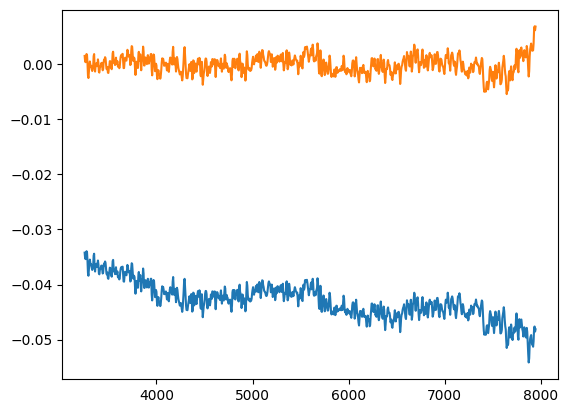

In [2]:
file = 'mangaHI-7443-1901.csv'

timeSeries = pd.read_csv(file, names = ('vHI','fHI', 'fBHI'))

time = timeSeries[22:-1].copy()
time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

plt.plot(time['vHI'], time['fBHI'])
plt.plot(time['vHI'], time['fHI'])

plt.show()

#### Dictionary creation for easier task execution

In [2]:
signalsDict = {
    1: "mangaHI-7443-1901.csv",
    2: "mangaHI-7443-1902.csv",
    3: "mangaHI-7972-3701.csv",
    4: "mangaHI-8077-12705.csv",
    5: "mangaHI-8081-12702.csv",
    6: "mangaHI-8084-3704.csv",
    7: "NGC 1068.txt",
    8: "NGC 3521.txt",
    9: "NGC 4565.txt",
    10: "NGC 4725.txt",
    11: "NGC 6822.txt"
}

In [15]:
# Dictionary to store results
metrics = {}

for key, file in signalsDict.items():
    file_extension = os.path.splitext(file)[-1].lower()

    try:
        if file_extension == ".csv":
            timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
            time = timeSeries[22:-1].copy()
            time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
            time = time.reset_index(drop=True).astype(float)
            
            x = time["vHI"].values
            y = time["fHI"].values

        elif file_extension == ".txt":
            timeSeries = pd.read_csv(file, sep=r'\s+', comment="#", names=["vHI", "fHI"])
            x = timeSeries["vHI"].values
            y = timeSeries["fHI"].values
        
        else:
            print(f"Skipping {file}: Error")
            continue

        # Mean and std dev calculation
        mean_value = np.mean(y)
        std_dev = np.std(y)

        # Store results
        metrics[file] = {"Mean": mean_value, "Std Dev": std_dev}

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Print results
for file, values in metrics.items():
    print(f"{file}: Mean = {values['Mean']:.5f}, Std Dev = {values['Std Dev']:.5f}")

mangaHI-7443-1901.csv: Mean = -0.00005, Std Dev = 0.00159
mangaHI-7443-1902.csv: Mean = 0.00103, Std Dev = 0.00258
mangaHI-7972-3701.csv: Mean = 0.00248, Std Dev = 0.02466
mangaHI-8077-12705.csv: Mean = 0.00004, Std Dev = 0.00132
mangaHI-8081-12702.csv: Mean = 0.37508, Std Dev = 0.87530
mangaHI-8084-3704.csv: Mean = 0.00021, Std Dev = 0.00143
NGC 1068.txt: Mean = 0.00968, Std Dev = 0.02833
NGC 3521.txt: Mean = 0.22182, Std Dev = 0.27392
NGC 4565.txt: Mean = 0.07983, Std Dev = 0.19134
NGC 4725.txt: Mean = 0.03011, Std Dev = 0.10266
NGC 6822.txt: Mean = 2.63865, Std Dev = 7.87491


### Spectral line definition using derivatives

#### Pipeline functions

In [ ]:
# Recursive Spectral Identification
def filter_spectral_regions(ranges):
    """Recursively filter spectral regions, starting with the largest integral region
    and stopping when no region exceeds 15x the mean integral of the remaining ones."""
    spectral_regions = []
    iteration = 1

    if not ranges:
        return []

    largest_region = max(ranges, key=lambda x: x[2])
    ranges.remove(largest_region)
    spectral_regions.append(largest_region)

    while ranges:
        mean_integral = np.mean([r[2] for r in ranges]) if ranges else 0
        new_spectral = [r for r in ranges if r[2] > 15 * mean_integral]

        if not new_spectral:
            break

        for region in new_spectral:
            spectral_regions.append(region)

        ranges = [r for r in ranges if r not in new_spectral]
        iteration += 1

    return spectral_regions


# Merge Adjacent Spectral Regions 
def merge_adjacent_spectral_regions(positive_regions, negative_regions):
    """Merges a negative spectral region with a following positive spectral region if they are consecutive.
    Also keeps track of the merged regions (in the form of their indices)"""

    global labeled_spectral_lines
    merged_spectral_lines = []
    merged_indices = set()

    for neg_idx, (neg_start, neg_end, _) in enumerate(negative_regions):
        for pos_idx, (pos_start, pos_end, _) in enumerate(positive_regions):
            if np.isclose(neg_end, pos_start, atol=1e-3):
                merged_spectral_lines.append((neg_start, pos_end))
                merged_indices.update({neg_idx, pos_idx})
                labeled_spectral_lines.append((neg_start, pos_end, "Adjacent Merge"))

    return merged_spectral_lines, merged_indices  # Return merged regions + indices of merged ones


# Merge Matching Spectral Regions
def merge_matching_spectral_regions(positive_regions, negative_regions, merged_indices, signal_flux):
    """Sort positive and negative integral regions from largest to smallest and pair them accordingly.
    If the gap between a pair is higher than the mean of the rest of the signal, label as "Two-Horned Matched".
    Otherwise, label as "Matched Merge"."""
    
    global labeled_spectral_lines

    # Filter out already-merged regions
    positive_filtered = [region for i, region in enumerate(positive_regions) if i not in merged_indices]
    negative_filtered = [region for i, region in enumerate(negative_regions) if i not in merged_indices]

    # Sort by integral value (descending)
    positive_sorted = sorted(positive_filtered, key=lambda x: x[2], reverse=True)
    negative_sorted = sorted(negative_filtered, key=lambda x: x[2], reverse=True)

    merged_regions = []
    num_pairs = min(len(positive_sorted), len(negative_sorted))

    for i in range(num_pairs):
        pos_start, pos_end, _ = positive_sorted[i]
        neg_start, neg_end, _ = negative_sorted[i]

        region_start = min(pos_start, neg_start)
        region_end = max(pos_end, neg_end)

        # Check the two-horned condition
        if region_end > region_start:
            gap_y_values = signal_flux[min(pos_end, neg_end):max(pos_start, neg_start)]

            if len(gap_y_values) > 0:
                min_gap_value = np.min(gap_y_values)

                # Mask to exclude spectral regions
                mask = np.ones_like(signal_flux, dtype=bool)
                for s, e, _ in labeled_spectral_lines:
                    mask[s:e] = False
                mean_rest_signal = np.mean(signal_flux[mask])

                if min_gap_value > mean_rest_signal:
                    label = "Two-Horned Matched"
                else:
                    label = "Matched Merge"
            else:
                label = "Matched Merge"
        else:
            label = "Matched Merge"

        merged_regions.append((region_start, region_end))
        labeled_spectral_lines.append((region_start, region_end, label))

        print(f"Pair {i+1}: Positive ({pos_start}-{pos_end}) and Negative ({neg_start}-{neg_end}) "
              f"--> Merged ({region_start}-{region_end}) | Label: {label}")

    return merged_regions



def merge_spectral_lines_into_two_horned(spectral_lines, signal_flux):
    """Merges two spectral lines into a two-horned signal if the minimum value in the region
    between them is greater than the mean value of the rest of the signal."""

    global labeled_spectral_lines
    if len(spectral_lines) < 2:
        return spectral_lines

    merged_spectral_lines = spectral_lines.copy()
    i = 0

    while i < len(merged_spectral_lines) - 1:
        start1, end1 = merged_spectral_lines[i]
        start2, end2 = merged_spectral_lines[i + 1]

        if end1 >= start2:
            i += 1
            continue

        gap_y_values = signal_flux[end1:start2]
        if len(gap_y_values) == 0:
            i += 1
            continue

        min_gap_value = np.min(gap_y_values)

        mask = np.ones_like(signal_flux, dtype=bool)
        for s, e in merged_spectral_lines:
            mask[s:e] = False
        mean_rest_signal = np.mean(signal_flux[mask])

        if min_gap_value > mean_rest_signal:
            merged_spectral_lines[i] = (start1, end2)
            del merged_spectral_lines[i + 1]
            labeled_spectral_lines.append((start1, end2, "Two-Horned Merge"))
        else:
            i += 1

    return merged_spectral_lines


# Ignore nested spectral lines (if any exist)
def ignore_nested_spectral_lines(spectral_lines):
    """Checks if one spectral line is fully inside another one and ignores it."""
    
    global labeled_spectral_lines
    if len(spectral_lines) < 2:
        return spectral_lines

    new_spectral_lines = spectral_lines.copy()
    i = 0

    while i < len(new_spectral_lines) - 1:
        start1, end1 = new_spectral_lines[i]
        start2, end2 = new_spectral_lines[i + 1]

        if (start2 > start1 and end2 < end1):
            del new_spectral_lines[i + 1]
            # Remove corresponding label as well
            labeled_spectral_lines = [
                (s, e, label) for s, e, label in labeled_spectral_lines
                if not (s == start2 and e == end2)
            ]
        else:
            i += 1

    return new_spectral_lines

#### Pipeline implementation

Load data and initialize time series

In [ ]:
# Load Data
file = "NGC 4725.txt"

file_extension = os.path.splitext(file)[-1].lower()

if file_extension == ".csv":
    timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
    time = timeSeries[22:-1].copy()
    time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
    time = time.reset_index(drop=True).astype(float)
    
    x = time["vHI"].values
    y = time["fHI"].values
    y_original = time["fBHI"].values

elif file_extension == ".txt":
    timeSeries = pd.read_csv(file, sep=r'\s+', comment="#", names=["vHI", "fHI"])
    x = timeSeries["vHI"].values
    y = timeSeries["fHI"].values
    y_original = None

Preprocess data (clip start and end to prevent extreme values due to polynomial fitting - to be changed if GPR is used instead of polynomial fitting)

In [ ]:
# Clip Data
clip_fraction = 0.17
n_points = len(x)
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

signal_velocity = x[start_index:end_index+1]
signal_flux = y[start_index:end_index+1]

Signal Smoothing

In [ ]:
# --- Smoothing Functions ---
def rolling_mean_smooth(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).mean().values

def savgol_smooth(signal, window_size, poly_order):
    if window_size % 2 == 0:
        window_size += 1  # Ensure odd window size
    return savgol_filter(signal, window_size, poly_order)

def hann_smooth(signal, window_size):
    if window_size % 2 == 0:
        window_size += 1  # Ensure odd window size
    hann_window = windows.hann(window_size)
    return np.convolve(signal, hann_window / hann_window.sum(), mode="same")

# Apply Smoothing
y_rolling = rolling_mean_smooth(signal_flux, window_size=5)
y_savgol = savgol_smooth(y_rolling, window_size=7, poly_order=3)
y_smoothed = hann_smooth(y_savgol, window_size=7)

if file_extension == ".txt":
    y_smoothed = signal_flux

Derivative computation - Area under-the-curve of derivative computation

In [ ]:
# Compute Derivative
derivative = np.gradient(y_smoothed, signal_velocity)

# Identify Positive and Negative Regions
positive_ranges = []
negative_ranges = []
current_start = None
current_sign = None

for i in range(1, len(derivative)):
    if derivative[i] > 0:
        if current_sign != 'positive':
            if current_sign == 'negative' and current_start is not None:
                integral = np.trapezoid(derivative[current_start:i], signal_velocity[current_start:i])
                negative_ranges.append((current_start, i, np.abs(integral)))
            current_start = i
            current_sign = 'positive'
    elif derivative[i] < 0:
        if current_sign != 'negative':
            if current_sign == 'positive' and current_start is not None:
                integral = np.trapezoid(derivative[current_start:i], signal_velocity[current_start:i])
                positive_ranges.append((current_start, i, np.abs(integral)))
            current_start = i
            current_sign = 'negative'

# Final integrals for last detected regions
if current_sign == 'positive' and current_start is not None:
    integral = np.trapezoid(derivative[current_start:], signal_velocity[current_start:])
    positive_ranges.append((current_start, len(derivative), integral))
elif current_sign == 'negative' and current_start is not None:
    integral = np.trapezoid(derivative[current_start:], signal_velocity[current_start:])
    negative_ranges.append((current_start, len(derivative), integral))

Compute the "meaningful" areas under the derivative curve (based on threshold) - Check Pipeline Functions cell for function definition

In [ ]:
# Initialize list for labelling of spectral lines
labeled_spectral_lines = []

# Recursively Filter Spectral Regions
positive_spectral_regions = filter_spectral_regions(positive_ranges)
negative_spectral_regions = filter_spectral_regions(negative_ranges)

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(signal_velocity, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(signal_velocity, signal_flux, label='Original Signal', alpha=0.4, color='blue')

# Highlight detected spectral regions
for region in positive_spectral_regions + negative_spectral_regions:
    axs[0].axvspan(signal_velocity[region[0]], signal_velocity[region[1]], color='yellow', alpha=0.3)

axs[0].set_title('Smoothed Signal with Spectral Regions')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(signal_velocity, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(signal_velocity, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(signal_velocity, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral regions in derivative plot
for region in positive_spectral_regions:
    axs[1].axvspan(signal_velocity[region[0]], signal_velocity[region[1]], color='yellow', alpha=0.5, label='Spectral Region' if region == positive_spectral_regions[0] else "")
for region in negative_spectral_regions:
    axs[1].axvspan(signal_velocity[region[0]], signal_velocity[region[1]], color='orange', alpha=0.5, label='Spectral Region' if region == negative_spectral_regions[0] else "")

axs[1].set_title('Derivative of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

Merge adjacent and matching spectral lines <br>
Adjacent: One positive + one negative spectral line next to each other <br>
Matching: Positive and negative integrals sorted in descending order and then matched respectively

In [ ]:
# Merge adjacent and matching spectral lines into one list
merged_spectral_lines_adjacent, merged_indices = merge_adjacent_spectral_regions(positive_spectral_regions, negative_spectral_regions)
merged_spectral_lines_matching = merge_matching_spectral_regions(positive_spectral_regions, negative_spectral_regions, merged_indices, signal_flux)

# Combine both lists and remove duplicates
merged_spectral_lines = list(set(merged_spectral_lines_adjacent + merged_spectral_lines_matching))
merged_spectral_lines.sort()

# Print Results
print("Spectral Lines Identified (Before Two-Horn Merge):")
for idx, (start, end) in enumerate(merged_spectral_lines, 1):
    print(f"  Spectral Line {idx}: Start = {signal_velocity[start]:.3f}, End = {signal_velocity[end]:.3f}")

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(signal_velocity, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(signal_velocity, signal_flux, label='Original Signal', alpha=0.4, color='blue')

# Highlight merged spectral lines
for start, end in merged_spectral_lines:
    axs[0].axvspan(signal_velocity[start], signal_velocity[end], color='yellow', alpha=0.3, label="Spectral Line" if start == merged_spectral_lines[0][0] else "")

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(signal_velocity, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(signal_velocity, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(signal_velocity, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral lines in derivative plot
for start, end in merged_spectral_lines:
    axs[1].axvspan(signal_velocity[start], signal_velocity[end], color='yellow', alpha=0.5, label="Spectral Line" if start == merged_spectral_lines[0][0] else "")

axs[1].set_title('Derivative of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

Remove nested spectral lines (false spectral lines detected within a two-horned signal) and merge correctly identified spectral lines into two-horned signal

In [ ]:
print("Removing nested spectral lines")
new_spectral_lines = ignore_nested_spectral_lines(merged_spectral_lines)

# Merge Close Spectral Lines into Two-Horn Signals
final_spectral_lines = merge_spectral_lines_into_two_horned(new_spectral_lines, signal_flux)

# Print Final Results
print("\nFinal Spectral Lines:")
for idx, (start, end) in enumerate(final_spectral_lines, 1):
    print(f"  Spectral Line {idx}: Start = {signal_velocity[start]:.3f}, End = {signal_velocity[end]:.3f}")

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(signal_velocity, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(signal_velocity, signal_flux, label='Original Signal', alpha=0.4, color='blue')

# Highlight final spectral lines
for start, end in final_spectral_lines:
    axs[0].axvspan(signal_velocity[start], signal_velocity[end], color='yellow', alpha=0.3, label="Spectral Line" if start == final_spectral_lines[0][0] else "")

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(signal_velocity, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(signal_velocity, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(signal_velocity, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral lines in derivative plot
for start, end in final_spectral_lines:
    axs[1].axvspan(signal_velocity[start], signal_velocity[end], color='yellow', alpha=0.5, label="Spectral Line" if start == final_spectral_lines[0][0] else "")

axs[1].set_title('Integral of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

Results visualization

In [ ]:
# Label Colors
label_color_map = {
    "Initial Filter": "blue",
    "Adjacent Merge": "orange",
    "Matched Merge": "green",
    "Two-Horned Merge": "red",
    "Nested Removed": "grey",
    "Two-Horned Matched": "purple"
}

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal Plot
axs[0].plot(signal_velocity, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(signal_velocity, signal_flux, label='Original Signal', alpha=0.4, color='blue')

# Highlight labeled spectral lines with specific colors
used_labels = set()
for start, end, label in labeled_spectral_lines:
    color = label_color_map.get(label, 'gray')
    if label not in used_labels:
        axs[0].axvspan(signal_velocity[start], signal_velocity[end], alpha=0.3, color=color, label=label)
        used_labels.add(label)
    else:
        axs[0].axvspan(signal_velocity[start], signal_velocity[end], alpha=0.3, color=color)

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative Plot
axs[1].plot(signal_velocity, derivative, label='Derivative of Signal', color='blue')

# Highlight labeled spectral lines here as well
used_labels = set()
for start, end, label in labeled_spectral_lines:
    color = label_color_map.get(label, 'gray')
    if label not in used_labels:
        axs[1].axvspan(signal_velocity[start], signal_velocity[end], alpha=0.5, color=color, label=label)
        used_labels.add(label)
    else:
        axs[1].axvspan(signal_velocity[start], signal_velocity[end], alpha=0.5, color=color)

axs[1].set_title('Integral of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

print("Final Spectral Line Summary")
for idx, (start, end, label) in enumerate(labeled_spectral_lines, 1):
    velocity_start = signal_velocity[start]
    velocity_end = signal_velocity[end]

    print(f"{idx:>2}. {label:20} — Start: {velocity_start:.3f}, End: {velocity_end:.3f}")